In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.3.1


In [5]:
%%bigquery flights_df --verbose
SELECT 
    date
    , airline
    , departure_airport
    , arrival_airport
    , departure_lat
    , departure_lon
    , arrival_lat
    , arrival_lon
    , departure_delay
    , arrival_delay
    , IF(arrival_delay >=  15, 1, 0) delayed
    
FROM `bigquery-samples.airline_ontime_data.flights`
WHERE 
    departure_airport = 'SFO' 
    AND date >= '2009-01-01' 
    AND date <= '2009-12-31'
    AND departure_delay <= 120
    AND departure_delay >= 1

Executing query with job ID: 3c2c12e0-4c35-4f96-8eb7-a203454d91bf
Query executing: 2.24s
Query complete after 2.57s


In [6]:
flights_processed_df = (flights_df
                        .filter(['departure_delay', 'delayed'])
                       )

<AxesSubplot:xlabel='departure_delay', ylabel='delayed'>

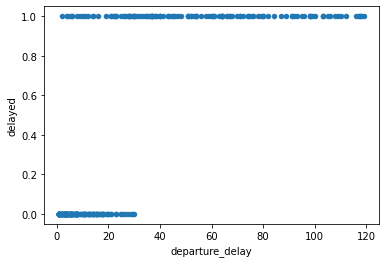

In [7]:
(flights_processed_df
 .sample(n=300, random_state=123)
 .plot.scatter('departure_delay', 'delayed')
)

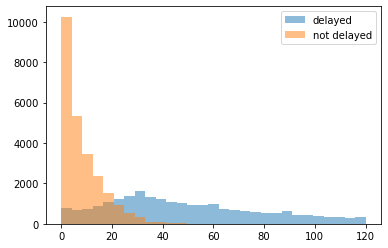

In [9]:
# what this shows is that there are very few instances where a flight arrives on time after being delayed for >= 30 minutes
bins = np.linspace(0, 120, 30)
# linspace(start, stop, number)
# returns equidistant numbers between start and stop, e.g. bins

plt.hist(flights_processed_df.query('delayed == 1')['departure_delay'], bins, alpha=0.5, label='delayed')
plt.hist(flights_processed_df.query('delayed == 0')['departure_delay'], bins, alpha=0.5, label='not delayed')
plt.legend(loc='upper right')
plt.show()

In [11]:
# shows the same logic, except that delayed is just about normally distributed

train_df = flights_processed_df.sample(frac=0.8, random_state=123)
# 80% of data in training df
test_df = flights_processed_df.drop(train_df.index)
# testing df is main df minus the indecies of the training set
train_labels = train_df.pop('delayed')
test_labels = test_df.pop('delayed')
# labels are actual values, in this case 'delayed'

In [12]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1, activation='sigmoid', input_shape=[len(train_df.keys())])
])
# only difference here is activation function, which allows the thing to be curvy

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
# adam:
    #best for non-stationary objectives
    
#

In [22]:
trained_data = model.fit(train_df, train_labels, epochs=10, callbacks=[tf.keras.callbacks.TensorBoard('logs/simple-regression')])

Epoch 1/10
1195/1195 [==============================] - 2s 2ms/step - loss: 0.3145 - accuracy: 0.8701
Epoch 2/10
1195/1195 [==============================] - 2s 2ms/step - loss: 0.3144 - accuracy: 0.8697
Epoch 3/10
1195/1195 [==============================] - 2s 2ms/step - loss: 0.3144 - accuracy: 0.8700
Epoch 4/10
1195/1195 [==============================] - 2s 2ms/step - loss: 0.3143 - accuracy: 0.8695
Epoch 5/10
1195/1195 [==============================] - 2s 2ms/step - loss: 0.3144 - accuracy: 0.8702
Epoch 6/10
1195/1195 [==============================] - 2s 2ms/step - loss: 0.3142 - accuracy: 0.8702
Epoch 7/10
1195/1195 [==============================] - 2s 2ms/step - loss: 0.3144 - accuracy: 0.8697
Epoch 8/10
1195/1195 [==============================] - 2s 2ms/step - loss: 0.3143 - accuracy: 0.8699
Epoch 9/10
1195/1195 [==============================] - 2s 2ms/step - loss: 0.3143 - accuracy: 0.8706
Epoch 10/10
1195/1195 [==============================] - 2s 2ms/step - loss: 0.314

In [24]:
test_predictions = model.predict(test_df).flatten()
test_predictions[:10]

array([0.9889735 , 0.9032272 , 0.999969  , 0.06955072, 0.999998  ,
       0.07996956, 0.9918218 , 0.936205  , 0.10516962, 0.22514078],
      dtype=float32)

In [25]:
predicted_labels = (test_predictions > 0.5).astype(int)
predicted_labels[:10]

array([1, 1, 1, 0, 1, 0, 1, 1, 0, 0])

In [26]:
results_df = pd.DataFrame({ 'Predicted': predicted_labels, 'Actual': test_labels })
results_df.head(10)

,Predicted,Actual
0,1,1
4,1,1
13,1,1
17,0,0
22,1,1
35,0,0
36,1,1
37,1,1
41,0,0
47,0,1


In [27]:
results = model.evaluate(test_df, test_labels)

299/299 [==============================] - 0s 1ms/step - loss: 0.3085 - accuracy: 0.8757


In [30]:
confusion_matrix = pd.crosstab(results_df['Actual'], results_df['Predicted'])
confusion_matrix

Predicted,0,1
Actual,,
0,4613,393
1,795,3756


In [31]:
TP = confusion_matrix.loc[1,1]
FP = confusion_matrix.loc[0,1]
TN = confusion_matrix.loc[0,0]
FN = confusion_matrix.loc[1,0]

In [33]:
accuracy = (TP+TN) / (TP+FP+FN+TN)
# overall accuracy
accuracy

0.8756932091660563

In [35]:
precision = TP / (TP+FP)
# positive prediction % that were correct
precision

0.9052783803326103

In [36]:
recall = TP / (TP+FN)
# positive labels % correct
recall

0.8253131179960448

In [37]:
f1 = 2*(recall*precision) / (recall+precision)
f1

0.863448275862069

In [38]:
tf.saved_model.save(model, 'model/1/')
# saves model to local file

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model/1/assets


In [40]:
%%bash
gsutil cp -r model/1/ gs://ml-course-test/models
    
# if bucket exists, save model to bucket

BucketNotFoundException: 404 gs://ml-course-test bucket does not exist.


CalledProcessError: Command 'b'gsutil cp -r model/1/ gs://ml-course-test/models\n    \n# if bucket exists, save model to bucket\n'' returned non-zero exit status 1.

In [42]:
%%bash
gcloud ai-platform models create flights_logistic_regression --region=us

Using endpoint [https://us-ml.googleapis.com/]
ERROR: (gcloud.ai-platform.models.create) Projects instance [ml-course-test] not found: <!DOCTYPE html>
<html lang=en>
  <meta charset=utf-8>
  <meta name=viewport content="initial-scale=1, minimum-scale=1, width=device-width">
  <title>Error 404 (Not Found)!!1</title>
  <style>
    *{margin:0;padding:0}html,code{font:15px/22px arial,sans-serif}html{background:#fff;color:#222;padding:15px}body{margin:7% auto 0;max-width:390px;min-height:180px;padding:30px 0 15px}* > body{background:url(//www.google.com/images/errors/robot.png) 100% 5px no-repeat;padding-right:205px}p{margin:11px 0 22px;overflow:hidden}ins{color:#777;text-decoration:none}a img{border:0}@media screen and (max-width:772px){body{background:none;margin-top:0;max-width:none;padding-right:0}}#logo{background:url(//www.google.com/images/branding/googlelogo/1x/googlelogo_color_150x54dp.png) no-repeat;margin-left:-5px}@media only screen and (min-resolution:192dpi){#logo{background:u

CalledProcessError: Command 'b'gcloud ai-platform models create flights_logistic_regression --region=us\n'' returned non-zero exit status 1.

In [43]:
%%bash

MODEL_DIR='gs://ml-course-test/models/1'
VERSION_NAME='v1'
MODEL_NAME='flights_logistic_regression'
FRAMEWORK='tensorflow'

gcloud ai-platform versions create $VERSION_NAME \
    --model $MODEL_NAME \
    --origin $MODEL_DIR \
    --runtime-version=1.14 \
    --framework $FRAMEWORK \
    --python-version=3.5

Using endpoint [https://ml.googleapis.com/]
API [ml.googleapis.com] not enabled on project [975569332631]. Would 
you like to enable and retry (this will take a few minutes)? (y/N)?  
ERROR: (gcloud.ai-platform.versions.create) PERMISSION_DENIED: AI Platform Training & Prediction API has not been used in project 975569332631 before or it is disabled. Enable it by visiting https://console.developers.google.com/apis/api/ml.googleapis.com/overview?project=975569332631 then retry. If you enabled this API recently, wait a few minutes for the action to propagate to our systems and retry.
- '@type': type.googleapis.com/google.rpc.Help
  links:
  - description: Google developers console API activation
    url: https://console.developers.google.com/apis/api/ml.googleapis.com/overview?project=975569332631
- '@type': type.googleapis.com/google.rpc.ErrorInfo
  domain: googleapis.com
  metadata:
    consumer: projects/975569332631
    service: ml.googleapis.com
  reason: SERVICE_DISABLED


CalledProcessError: Command 'b"\nMODEL_DIR='gs://ml-course-test/models/1'\nVERSION_NAME='v1'\nMODEL_NAME='flights_logistic_regression'\nFRAMEWORK='tensorflow'\n\ngcloud ai-platform versions create $VERSION_NAME \\\n    --model $MODEL_NAME \\\n    --origin $MODEL_DIR \\\n    --runtime-version=1.14 \\\n    --framework $FRAMEWORK \\\n    --python-version=3.5\n"' returned non-zero exit status 1.